# Capstone Two - Modeling

Capstone Project Two : Springboard Data Science career track

Notebook by Jos Evans

Introduction:

## 1. The Problem:

Traders in financial markets typically use charts and 'technical indicators' to indentify entry and exit points.  These 'technical indicators' are generally derivatives of price and/or volume, and after having used them for many years I have come to believe that most work only some of the time, some are horrible and some are very useful.  Here I will explore using machine learning to test whether there is any predictive power to a confluence of these indicators, and I will also empirically test the usefulness of the indicators that I believe to be reliable, to see if I am indeed correct.

## 2. The Data:

I have been collecting intraday trading data for Bitcoin vs USD from Tiingo with a frequency of 1 minute for about 6 weeks, and as of the 17th of September 2020 that amounted to about 56,000 rows of data.

## 3. The Question of Interest:

I have calculated a reward metric which is a figure that risk-adjusts the overall profit on a trade, by dividing the profit by the maximum drawdown during the holding period.  I have initially made the trade holding period 5 minutes, but will eventually explore many different timeframes.  I will add a large range of technical indicators as features to the dataset, and then explore whether they have predictive power in predicting reward as y.

## 4. Import the necessary libraries and the data:
To start, let's first import all the necessary modules and libraries and read the data set into the Pandas dataframe. These are some data wrangling and exploratory analysis from the previous part. For detailed EDA, see the following:

https://github.com/londonjevans/Capstone-Two/blob/master/Capstone%20Two%20EDA.ipynb



In [213]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

IntraDf = pd.read_csv('/Users/josevans/Library/Mobile Documents/com~apple~CloudDocs/Python files/BTCintraday.csv', index_col='date', parse_dates=True)

In [214]:
IntraDf.head()

,high,open,tradesDone,close,low,volume,shifted,long_reward,short_reward
date,,,,,,,,,
2020-08-06 03:25:00+00:00,11632.857198,11628.661773,661.0,11627.304298,11622.331438,64.659103,11640.182026,12.877727,-1.000000
2020-08-06 03:26:00+00:00,11634.698542,11628.880651,510.0,11633.023039,11628.452068,65.223952,11636.672888,3.649849,-0.509828
2020-08-06 03:27:00+00:00,11643.130954,11633.849983,660.0,11636.906148,11633.845233,42.325653,11641.185453,4.279305,-1.000000
2020-08-06 03:28:00+00:00,11640.358176,11634.990781,511.0,11637.230756,11634.909007,25.039172,11633.837668,-1.000000,0.857989
2020-08-06 03:29:00+00:00,11639.253297,11635.244462,511.0,11636.846520,11633.373031,29.803953,11635.018432,-0.607570,0.421322


Here is the code I wrote to calculate the reward - I will use it later for a variety of timeframes

In [3]:
def calc_reward(df, num_periods):
    
    df['shifted'] = df.close.shift(-num_periods)
    
    long_reward = []
    short_reward = []

    for i in range(len(df)+1):
        
        min_price = df.iloc[i:(i+1+num_periods)].close.min()
        max_price = df.iloc[i:(i+1+num_periods)].close.max()
        
        try:
        
            long_reward.append((df.iloc[i].shifted - df.iloc[i].close) / np.where(((df.iloc[i].close - min_price) <= -1 or (df.iloc[i].close - min_price) >= 1), abs(df.iloc[i].close-min_price), 1))
            short_reward.append((df.iloc[i].close - df.iloc[i].shifted) / np.where(((max_price - df.iloc[i].close) <= -1 or (max_price - df.iloc[i].close) >= 1), abs(max_price - df.iloc[i].close), 1))
        
        except IndexError:
        
            continue
            
    df['long_reward'] = long_reward    
    df['short_reward'] = short_reward   

## 5. Feature Engineering

I will try two methods here, both of which involve calculating the following technical indicators; Ichimoku Clouds, RSI, MACD, Moving Averages(simple and exponential), Bollinger Bands and trading ranges. For the first method I will leave all the indicators as their numerical calculations (then scale), and for the second methood I will turn them all into binary classifications (such as 1 if the price is above the moving average).  I will model both datasets and see if there is any difference in predictive abilities. Note I could not include some features in method 1 because they are so closely correlated, such as Ichimoku cloud and bollinger bands.

## Features for method 1

In [215]:
def calc_rsi(df, period):
    # What Is the Relative Strength Index (RSI)?
    # The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.
    # https://www.investopedia.com/terms/r/rsi.asp
    delta = df.close.diff()
    window = period
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()
    rsi= 100-100/(1+RS_up/RS_down)

    df['RSI'] = rsi
    
def engineer(df):
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    df['realised_vol'] = df.log_ret.rolling(window=30).std()*np.sqrt(252)*100
    tmparray = [8, 30, 100, 200]
    df['dayRangeAbs'] = abs(df.high - df.low)
    calc_rsi(df, 15)
    df['upperboll'] = df.close.rolling(window=20).mean() + (df.close.rolling(window=20).std() * 2)
    
     
    for num in tmparray:
        df['SMA{}'.format(num)] = df.close.rolling(window=num).mean()
        
    
    cols_to_change = [col for col in df.columns if 'SMA' in col] + [col for col in df.columns if 'EMA' in col]
    
    for col in df[cols_to_change]:    
        df['distance_from_'+col] = np.where((df[col] > df['close']), ((df['close'] - df[col])/df[col]*100), ((df['close'] - df[col])/df[col]*100)) 
           
    #calc macd
    exp1 = df.close.ewm(span=12, adjust=False).mean()
    exp2 = df.close.ewm(span=26, adjust=False).mean()
    df['macd'] = exp1-exp2
    df['signal'] = df.macd.ewm(span=9, adjust=False).mean()
    df['macd_signal_roc'] = ((df.macd - df.signal) - (df.macd.shift(1) - df.signal.shift(1)))   
    df.drop('log_ret', axis=1, inplace=True)
    
    new = []
    
    def custom_round(x, base=25):
        return int(base * round(float(x)/base))

    df['base'] = df.close.apply(lambda x: custom_round(x))
    
    for i in range(len(df)):
        VPOC = pd.DataFrame(df.iloc[:(i+1)].groupby('base').volume.sum())
        new.append(VPOC.idxmax()[0])
    
    df['vpoc'] = new
    
    return df
    
    
        
         
Method1Df = engineer(IntraDf)

In [216]:
Method1Df.head()

,high,open,tradesDone,close,low,volume,shifted,long_reward,short_reward,realised_vol,...,SMA200,distance_from_SMA8,distance_from_SMA30,distance_from_SMA100,distance_from_SMA200,macd,signal,macd_signal_roc,base,vpoc
date,,,,,,,,,,,,,,,,,,,,,
2020-08-06 03:25:00+00:00,11632.857198,11628.661773,661.0,11627.304298,11622.331438,64.659103,11640.182026,12.877727,-1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,11625,11625
2020-08-06 03:26:00+00:00,11634.698542,11628.880651,510.0,11633.023039,11628.452068,65.223952,11636.672888,3.649849,-0.509828,NaN,...,NaN,NaN,NaN,NaN,NaN,0.456196,0.091239,0.364957,11625,11625
2020-08-06 03:27:00+00:00,11643.130954,11633.849983,660.0,11636.906148,11633.845233,42.325653,11641.185453,4.279305,-1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,1.118179,0.296627,0.456595,11625,11625
2020-08-06 03:28:00+00:00,11640.358176,11634.990781,511.0,11637.230756,11634.909007,25.039172,11633.837668,-1.000000,0.857989,NaN,...,NaN,NaN,NaN,NaN,NaN,1.649979,0.567297,0.261129,11625,11625
2020-08-06 03:29:00+00:00,11639.253297,11635.244462,511.0,11636.846520,11633.373031,29.803953,11635.018432,-0.607570,0.421322,NaN,...,NaN,NaN,NaN,NaN,NaN,2.017177,0.857273,0.077222,11625,11625


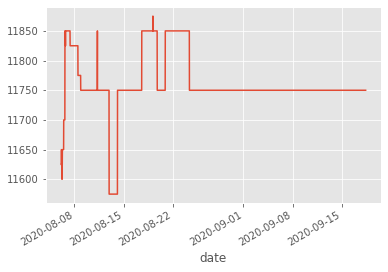

In [217]:
Method1Df.vpoc.plot()
plt.show()

## Features for method 2

In [218]:
IntraDf = pd.read_csv('/Users/josevans/Library/Mobile Documents/com~apple~CloudDocs/Python files/BTCintraday.csv', index_col='date', parse_dates=True)

def ichimoku(d):
    # What is the Ichimoku Cloud?
    # The Ichimoku Cloud is a collection of technical indicators that show support and resistance levels, as well as momentum and trend direction. It does this by taking multiple averages and plotting them on the chart. It also uses these figures to compute a "cloud" which attempts to forecast where the price may find support or resistance in the future.
    # https://www.investopedia.com/terms/i/ichimoku-cloud.asp
    high_prices = d['high']
    close_prices = d['close']
    low_prices = d['low']
    nine_period_high = d['high'].rolling(window= 9 ).max()
    nine_period_low = d['low'].rolling(window= 9 ).min()
    d['tenkan_sen'] = (nine_period_high + nine_period_low) /2

    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    period26_high = high_prices.rolling(window=26).max()
    period26_low = low_prices.rolling(window=26).min()
    d['kijun_sen'] = (period26_high + period26_low) / 2
    
    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)
    
    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    period52_high = high_prices.rolling(window=52).max()
    period52_low = low_prices.rolling(window=52).min()
    d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)
    d['senkou_binary_uptrend'] = np.where((close_prices >= d['senkou_span_a']) & (close_prices >= d['senkou_span_b']), 1, 0)
    d['senkou_binary_downtrend'] = np.where((close_prices <= d['senkou_span_a']) & (close_prices <= d['senkou_span_b']), 1, 0)
    d['ydaysenkou_binary_uptrend'] = d['senkou_binary_uptrend'].shift(1)
    d['ydaysenkou_binary_downtrend'] = d['senkou_binary_downtrend'].shift(1)                             

def calc_rsi(df, period):
    # What Is the Relative Strength Index (RSI)?
    # The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.
    # https://www.investopedia.com/terms/r/rsi.asp
    delta = df.close.diff()
    window = period
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()
    rsi= 100-100/(1+RS_up/RS_down)

    df['RSI'] = rsi

    df['binary_RSI_oversold'] = np.where((df['RSI'] <= 30), 1, 0)
    df['ydaybinary_RSI_oversold'] = df['binary_RSI_oversold'].shift(1)
    df['binary_RSI_overbought'] = np.where((df['RSI'] >= 80), 1, 0)
    df['ydaybinary_RSI_overbought'] = df['binary_RSI_overbought'].shift(1)
    
def convert_mas(df):
    # This is for calculating in binary whether the price is above or below each moving average
    cols_to_change = [col for col in df.columns if 'SMA' in col] + [col for col in df.columns if 'EMA' in col]
    for col in df[cols_to_change]:
        df['binary_'+col] = np.where((df[col] > df['close']) | df[col].isnull(), 0, 1)
        df['distance_from_'+col] = np.where((df[col] > df['close']), ((df['close'] - df[col])/df[col]*100), ((df['close'] - df[col])/df[col]*100)) 
        df.drop(col, axis = 1, inplace=True)
    new_cols_to_change = [col for col in df.columns if 'binary_SMA' in col] + [col for col in df.columns if 'binary_EMA' in col]
    for col in df[new_cols_to_change]:
        df['yday'+col] = df[col].shift(1)
    
def detect(df):
    # this is for pinpointing in binary when a golden cross or death cross happens, as traders believe that returns are better or worse after these triggers
    # https://www.investopedia.com/ask/answers/121114/what-difference-between-golden-cross-and-death-cross-pattern.asp
    df['binary_gold_cross_8_30'] = np.where((df['binary_SMA8'] == 0) & (df['binary_SMA30'] == 1) & (df['ydaybinary_SMA8'] == 1) & (df['ydaybinary_SMA30'] == 1), 1, 0)
    df['binary_death_cross_8_30'] = np.where((df['binary_SMA8'] == 0) & (df['binary_SMA30'] == 1) & (df['ydaybinary_SMA8'] == 0) & (df['ydaybinary_SMA30'] == 0), 1, 0)
    df['binary_gold_cross_30_100'] = np.where((df['binary_SMA30'] == 0) & (df['binary_SMA100'] == 1) & (df['ydaybinary_SMA30'] == 1) & (df['ydaybinary_SMA100'] == 1), 1, 0)
    df['binary_death_cross_30_100'] = np.where((df['binary_SMA30'] == 0) & (df['binary_SMA100'] == 1) & (df['ydaybinary_SMA30'] == 0) & (df['ydaybinary_SMA100'] == 0), 1, 0)
    df['binary_gold_cross_100_200'] = np.where((df['binary_SMA100'] == 0) & (df['binary_SMA200'] == 1) & (df['ydaybinary_SMA100'] == 1) & (df['ydaybinary_SMA200'] == 1), 1, 0)
    df['binary_death_cross_100_200'] = np.where((df['binary_SMA100'] == 0) & (df['binary_SMA200'] == 1) & (df['ydaybinary_SMA100'] == 0) & (df['ydaybinary_SMA200'] == 0), 1, 0)
    df['ydaybinary_gold_cross_8_30'] = df['binary_gold_cross_8_30'].shift(1)
    df['ydaybinary_death_cross_8_30'] = df['binary_death_cross_8_30'].shift(1)
    df['ydaybinary_gold_cross_30_100'] = df['binary_gold_cross_30_100'].shift(1)
    df['ydaybinary_death_cross_30_100'] = df['binary_death_cross_30_100'].shift(1)
    df['ydaybinary_gold_cross_100_200'] = df['binary_gold_cross_100_200'].shift(1)
    df['ydaybinary_death_cross_100_200'] = df['binary_death_cross_100_200'].shift(1)
    

def binary_engineered(df):
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    df['realised_vol'] = df.log_ret.rolling(window=30).std()*np.sqrt(252)*100
    tmparray = [8, 30, 100, 200]
    df['dayRangeAbs'] = abs(df.high - df.low)
    
    df['binaryNR7'] = np.where((df.dayRangeAbs <= df.dayRangeAbs.rolling(window=7).min()), 1, 0)
    df['binaryNR4'] = np.where((df.dayRangeAbs <= df.dayRangeAbs.rolling(window=4).min()), 1, 0)
    df['ydaybinaryNR7'] = df['binaryNR7'].shift(1)
    df['ydaybinaryNR4'] = df['binaryNR4'].shift(1)
    calc_rsi(df, 15)
    ichimoku(df)
    df['upperboll'] = df.close.rolling(window=20).mean() + (df.close.rolling(window=20).std() * 2)
    df['lowerboll'] = df.close.rolling(window=20).mean() - (df.close.rolling(window=20).std() * 2)
    df['binaryaboveupperboll'] = np.where((df.open >= df.upperboll), 1, 0)
    df['binarybelowlowerboll'] = np.where((df.open <= df.lowerboll), 1, 0)
    df['ydaybinaryaboveupperboll'] = df['binaryaboveupperboll'].shift(1)
    df['ydaybinarybelowlowerboll'] = df['binarybelowlowerboll'].shift(1)
    
    
    for num in tmparray:
        df['SMA{}'.format(num)] = df.close.rolling(window=num).mean()
        
    #calc macd
    exp1 = df.close.ewm(span=12, adjust=False).mean()
    exp2 = df.close.ewm(span=26, adjust=False).mean()
    df['macd'] = exp1-exp2
    df['signal'] = df.macd.ewm(span=9, adjust=False).mean()
    df['ydaymacd'] = df.macd.shift(1)
    df['macd_bullish_cross'] = np.where((df.macd > df.signal) & (df.ydaymacd <= df.signal), 1, 0)
    df['macd_bearish_cross'] = np.where((df.macd < df.signal) & (df.ydaymacd >= df.signal), 1, 0)
    df['macd_signal_roc'] = ((df.macd - df.signal) - (df.macd.shift(1) - df.signal.shift(1)))
    
    convert_mas(df)
    detect(df)    
    df.drop(['log_ret', 'macd', 'signal', 'ydaymacd', 'kijun_sen', 'upperboll', 'lowerboll', 'tenkan_sen', 'senkou_span_a', 'senkou_span_b'], axis=1, inplace=True)
    
    new = []
    
    for i in range(len(df)):
        new.append(np.where((df.iloc[i].close >= Method1Df.iloc[i].vpoc), 1, 0))
    
    df['binary_vpoc'] = new
    df['binary_vpoc'] = df['binary_vpoc'].astype(int)
    
    return df

Method2Df = binary_engineered(IntraDf)

In [219]:
Method2Df.head()

,high,open,tradesDone,close,low,volume,shifted,long_reward,short_reward,realised_vol,...,binary_death_cross_30_100,binary_gold_cross_100_200,binary_death_cross_100_200,ydaybinary_gold_cross_8_30,ydaybinary_death_cross_8_30,ydaybinary_gold_cross_30_100,ydaybinary_death_cross_30_100,ydaybinary_gold_cross_100_200,ydaybinary_death_cross_100_200,binary_vpoc
date,,,,,,,,,,,,,,,,,,,,,
2020-08-06 03:25:00+00:00,11632.857198,11628.661773,661.0,11627.304298,11622.331438,64.659103,11640.182026,12.877727,-1.000000,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
2020-08-06 03:26:00+00:00,11634.698542,11628.880651,510.0,11633.023039,11628.452068,65.223952,11636.672888,3.649849,-0.509828,NaN,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-08-06 03:27:00+00:00,11643.130954,11633.849983,660.0,11636.906148,11633.845233,42.325653,11641.185453,4.279305,-1.000000,NaN,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-08-06 03:28:00+00:00,11640.358176,11634.990781,511.0,11637.230756,11634.909007,25.039172,11633.837668,-1.000000,0.857989,NaN,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-08-06 03:29:00+00:00,11639.253297,11635.244462,511.0,11636.846520,11633.373031,29.803953,11635.018432,-0.607570,0.421322,NaN,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1


## 6. Data Prep

All of the nan values are due to technical indicators that require price windows for calculation, so I have no choice but to drop these rather than fill.  It will only lead to a reduction of about 200 rows out of 55k plus though.

I will also drop all non binary columns for method 2, and most price columns for method 1.

In [220]:
cols1drop = ['high', 'close', 'low', 'open', 'shifted', 'long_reward', 'short_reward', 'SMA8', 'SMA30', 'SMA100', 'SMA200']

y1long = Method1Df.dropna().long_reward
y1short = Method1Df.dropna().short_reward

Method1Df = Method1Df.drop(cols1drop, axis=1).dropna()

In [221]:
cols2drop = [col for col in Method2Df.columns if (Method2Df[col].max() > 1) or (Method2Df[col].min() < 0)]

y2long = Method2Df.long_reward.dropna()
y2short = Method2Df.short_reward.dropna()

Method2Df = Method2Df.drop(cols2drop, axis=1).dropna()

In [222]:
Method1Df.head()

,tradesDone,volume,realised_vol,dayRangeAbs,RSI,upperboll,distance_from_SMA8,distance_from_SMA30,distance_from_SMA100,distance_from_SMA200,macd,signal,macd_signal_roc,base,vpoc
date,,,,,,,,,,,,,,,
2020-08-06 06:44:00+00:00,254.0,26.032228,0.941138,1.126751,51.646447,11674.308032,-0.032728,-0.008612,0.238982,0.260840,2.254066,3.928737,0.035173,11650,11625
2020-08-06 06:45:00+00:00,400.0,28.658804,0.680761,2.310505,50.046330,11673.837027,-0.058720,-0.053539,0.189008,0.213681,1.501646,3.443319,-0.267001,11650,11625
2020-08-06 06:46:00+00:00,256.0,18.918678,0.680671,3.294665,47.195694,11674.016038,-0.044984,-0.052597,0.186432,0.212924,0.896986,2.934052,-0.095393,11650,11650
2020-08-06 06:47:00+00:00,389.0,18.484686,0.624713,4.494130,40.447439,11673.731396,-0.006023,-0.023103,0.210637,0.238568,0.659629,2.479168,0.217527,11650,11650
2020-08-06 06:48:00+00:00,215.0,10.288374,0.611370,2.468358,48.889996,11673.748092,0.034592,0.012773,0.244067,0.273616,0.801553,2.143645,0.477447,11675,11650


In [223]:
Method1Df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57054 entries, 2020-08-06 06:44:00+00:00 to 2020-09-18 09:00:00+00:00
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tradesDone            57054 non-null  float64
 1   volume                57054 non-null  float64
 2   realised_vol          57054 non-null  float64
 3   dayRangeAbs           57054 non-null  float64
 4   RSI                   57054 non-null  float64
 5   upperboll             57054 non-null  float64
 6   distance_from_SMA8    57054 non-null  float64
 7   distance_from_SMA30   57054 non-null  float64
 8   distance_from_SMA100  57054 non-null  float64
 9   distance_from_SMA200  57054 non-null  float64
 10  macd                  57054 non-null  float64
 11  signal                57054 non-null  float64
 12  macd_signal_roc       57054 non-null  float64
 13  base                  57054 non-null  int64  
 14  vpoc                  5

In [224]:
Method2Df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57252 entries, 2020-08-06 03:26:00+00:00 to 2020-09-18 09:00:00+00:00
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   binaryNR7                       57252 non-null  int64  
 1   binaryNR4                       57252 non-null  int64  
 2   ydaybinaryNR7                   57252 non-null  float64
 3   ydaybinaryNR4                   57252 non-null  float64
 4   binary_RSI_oversold             57252 non-null  int64  
 5   ydaybinary_RSI_oversold         57252 non-null  float64
 6   binary_RSI_overbought           57252 non-null  int64  
 7   ydaybinary_RSI_overbought       57252 non-null  float64
 8   senkou_binary_uptrend           57252 non-null  int64  
 9   senkou_binary_downtrend         57252 non-null  int64  
 10  ydaysenkou_binary_uptrend       57252 non-null  float64
 11  ydaysenkou_binary_downtrend     57252 non-null

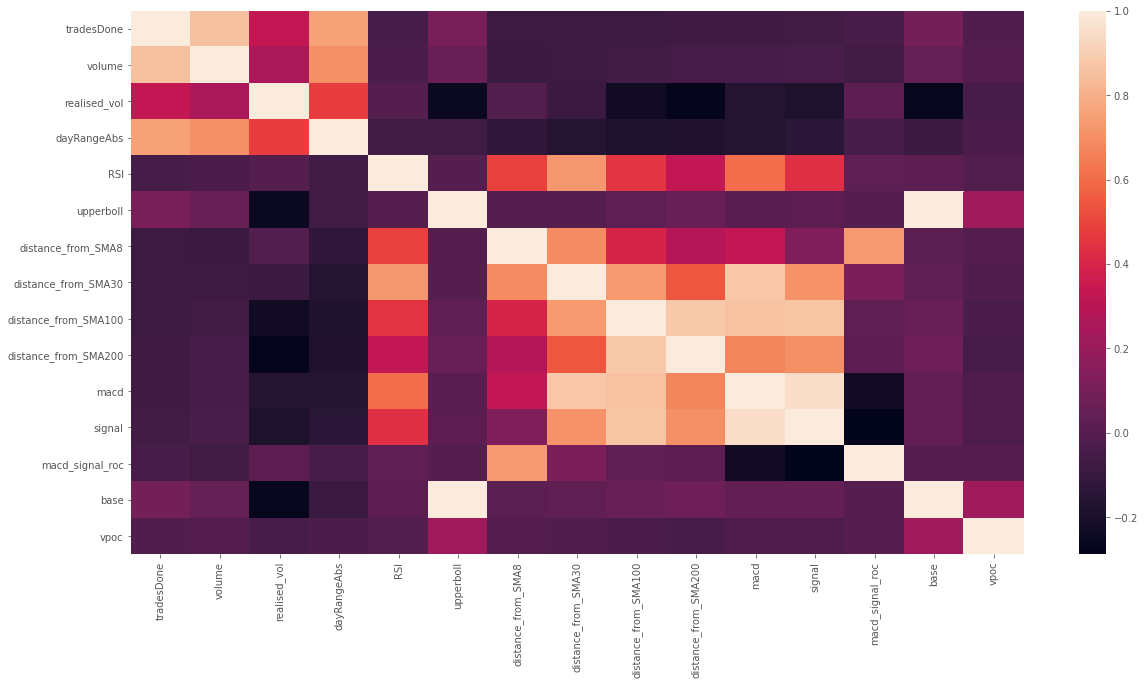

In [135]:
plt.figure(figsize=(20,10))
sns.heatmap(Method1Df.corr())
plt.show()

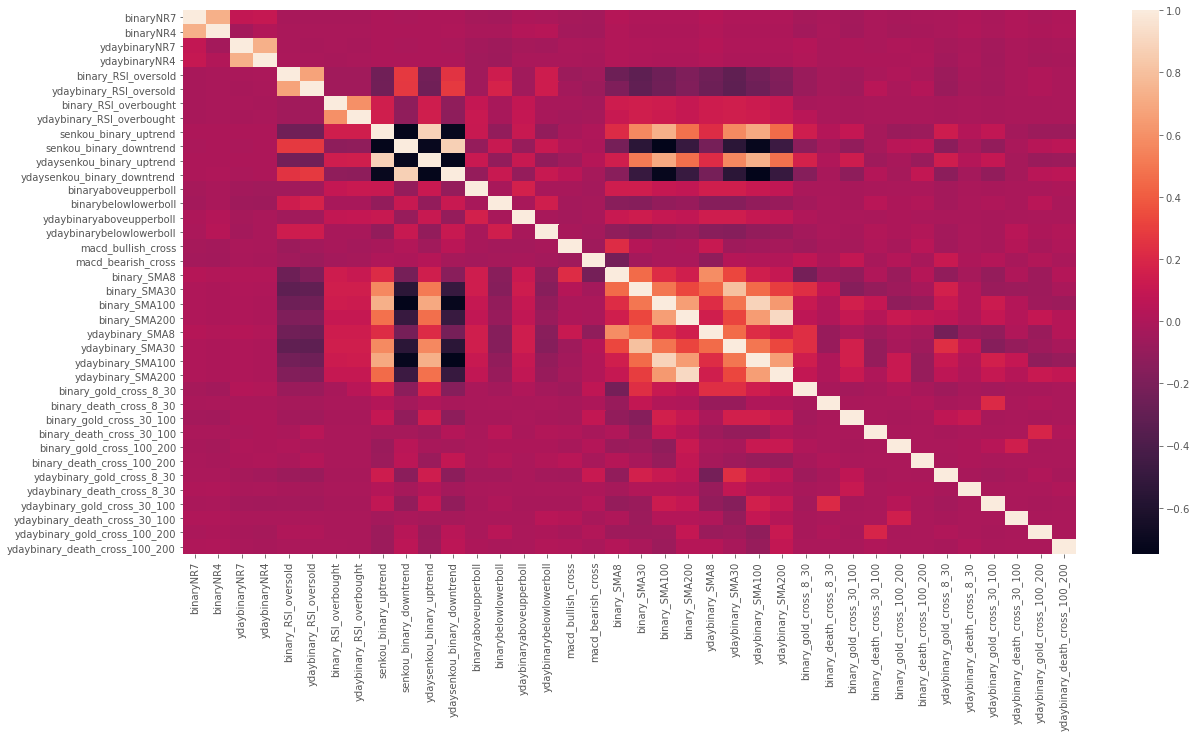

In [136]:
plt.figure(figsize=(20,10))
sns.heatmap(Method2Df.corr())
plt.show()

## 6. Applying the Machine Learning models:
This is a supervised regression problem. I will explore the following regression models:

Lasso Regression
Random Forest
Elastic Net
Neural network
Gradient Boost
K Neighbours

I'll cross validate each to find the best and then hyperparamater tune after that.


In [225]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

In [234]:
Xs = [Method1Df.iloc[:-5], Method1Df.iloc[:-5], Method2Df.iloc[:-4], Method2Df.iloc[:-4]]
Ys = [y1long, y1short, y2long, y2short]

scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(quantile_range=(25, 75)), PowerTransformer(method='yeo-johnson'), QuantileTransformer(output_distribution='normal'), QuantileTransformer(output_distribution='uniform'),  Normalizer()]

for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(Xs[i], Ys[i], test_size=0.2, random_state=i)
    
    for k in range(len(scalers)):
        sc = scalers[k]
        
        pipelines = []
        pipelines.append(('ScaledLR', Pipeline([('Scaler', sc),('LR',LinearRegression())])))
        pipelines.append(('ScaledLASSO', Pipeline([('Scaler', sc),('LASSO', Lasso())])))
        pipelines.append(('ScaledEN', Pipeline([('Scaler', sc),('EN', ElasticNet())])))
        pipelines.append(('ScaledKNN', Pipeline([('Scaler', sc),('KNN', KNeighborsRegressor())])))
        pipelines.append(('ScaledCART', Pipeline([('Scaler', sc),('CART', DecisionTreeRegressor())])))
        pipelines.append(('ScaledGBM', Pipeline([('Scaler', sc),('GBM', GradientBoostingRegressor())])))
        
        
        results = []
        names = []
   
        for name, model in pipelines:
            kfold = KFold(n_splits=10, random_state=21)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
            results.append(cv_results)
            names.append(name)
            msg = "%s %s: %f (%f)" % (name, scalers[k], cv_results.mean(), cv_results.std())
            print(msg)



ScaledLR StandardScaler(): -10.171437 (0.357350)
ScaledLASSO StandardScaler(): -10.293851 (0.415152)
ScaledEN StandardScaler(): -10.228725 (0.396111)
ScaledKNN StandardScaler(): -10.130776 (0.341832)
ScaledCART StandardScaler(): -13.427949 (0.813409)
ScaledGBM StandardScaler(): -10.083055 (0.332852)
ScaledLR MinMaxScaler(): -10.171437 (0.357350)
ScaledLASSO MinMaxScaler(): -10.405849 (0.434849)
ScaledEN MinMaxScaler(): -10.405849 (0.434849)
ScaledKNN MinMaxScaler(): -9.958335 (0.346869)
ScaledCART MinMaxScaler(): -13.450970 (0.807733)
ScaledGBM MinMaxScaler(): -10.100403 (0.347000)
ScaledLR MaxAbsScaler(): -10.171437 (0.357350)
ScaledLASSO MaxAbsScaler(): -10.405849 (0.434849)
ScaledEN MaxAbsScaler(): -10.405849 (0.434849)
ScaledKNN MaxAbsScaler(): -10.095079 (0.315563)
ScaledCART MaxAbsScaler(): -13.521944 (0.526161)
ScaledGBM MaxAbsScaler(): -10.104237 (0.342575)
ScaledLR RobustScaler(quantile_range=(25, 75)): -10.171437 (0.357350)
ScaledLASSO RobustScaler(quantile_range=(25, 75)): -

In [244]:
X_train, X_test, y_train, y_test = train_test_split(Method2Df.iloc[:-4], y2long, test_size=0.2, random_state=i)
    
pipelines = []
pipelines.append(('Method 2 LR', Pipeline([('LR',LinearRegression())])))
pipelines.append(('Method 2 LASSO', Pipeline([('LASSO', Lasso())])))
pipelines.append(('Method 2 EN', Pipeline([('EN', ElasticNet())])))
pipelines.append(('Method 2 KNN', Pipeline([('KNN', KNeighborsRegressor())])))
pipelines.append(('Method 2 CART', Pipeline([('CART', DecisionTreeRegressor())])))
pipelines.append(('Method 2 GBM', Pipeline([('GBM', GradientBoostingRegressor())])))
        
results = []
names = []
   
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Method 2 LR: -9.870694 (0.695573)
Method 2 LASSO: -10.330277 (0.704906)
Method 2 EN: -10.302675 (0.705818)
Method 2 KNN: -10.856585 (0.661140)
Method 2 CART: -10.743912 (0.733221)
Method 2 GBM: -9.842063 (0.668284)


In [245]:
X_train, X_test, y_train, y_test = train_test_split(Method2Df.iloc[:-4], y2short, test_size=0.2, random_state=i)
    
pipelines = []
pipelines.append(('Method 2 LR', Pipeline([('LR',LinearRegression())])))
pipelines.append(('Method 2 LASSO', Pipeline([('LASSO', Lasso())])))
pipelines.append(('Method 2 EN', Pipeline([('EN', ElasticNet())])))
pipelines.append(('Method 2 KNN', Pipeline([('KNN', KNeighborsRegressor())])))
pipelines.append(('Method 2 CART', Pipeline([('CART', DecisionTreeRegressor())])))
pipelines.append(('Method 2 GBM', Pipeline([('GBM', GradientBoostingRegressor())])))
        
results = []
names = []
   
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Method 2 LR: -10.518655 (1.321562)
Method 2 LASSO: -10.948925 (1.261179)
Method 2 EN: -10.922960 (1.263694)
Method 2 KNN: -11.236050 (1.196373)
Method 2 CART: -11.369029 (1.266351)
Method 2 GBM: -10.512239 (1.291825)


## 8. Learnings, and model tuning

The 2nd, binary dataframe appears most promising, and the Gradient Boosting model consistently outperforms. CART performed horribly all around.  I will try XG Boost and neural nets also now and compare.

In [246]:
from xgboost import XGBRegressor

for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(Xs[i], Ys[i], test_size=0.2, random_state=i)
    
    for k in range(len(scalers)):
        sc = scalers[k]
        
        pipelines = []
        pipelines.append(('ScaledXGBoost', Pipeline([('Scaler', sc),('XGBR',XGBRegressor())])))
        
        results = []
        names = []
   
        for name, model in pipelines:
            kfold = KFold(n_splits=10, random_state=21)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
            results.append(cv_results)
            names.append(name)
            msg = "%s %s: %f (%f)" % (name, scalers[k], cv_results.mean(), cv_results.std())
            print(msg)

ScaledXGBoost StandardScaler(): -10.003892 (0.461435)
ScaledXGBoost MinMaxScaler(): -9.974489 (0.454006)
ScaledXGBoost MaxAbsScaler(): -9.988501 (0.461040)
ScaledXGBoost RobustScaler(quantile_range=(25, 75)): -9.993206 (0.460994)
ScaledXGBoost PowerTransformer(): -10.025626 (0.436676)
ScaledXGBoost QuantileTransformer(output_distribution='normal'): -9.990638 (0.469473)
ScaledXGBoost QuantileTransformer(): -9.994518 (0.455399)
ScaledXGBoost Normalizer(): -10.082966 (0.396811)
ScaledXGBoost StandardScaler(): -10.801184 (1.283114)
ScaledXGBoost MinMaxScaler(): -10.782898 (1.383752)
ScaledXGBoost MaxAbsScaler(): -10.789864 (1.376904)
ScaledXGBoost RobustScaler(quantile_range=(25, 75)): -10.784973 (1.223857)
ScaledXGBoost PowerTransformer(): -10.754390 (1.332615)
ScaledXGBoost QuantileTransformer(output_distribution='normal'): -10.839035 (1.394626)
ScaledXGBoost QuantileTransformer(): -10.786263 (1.407724)
ScaledXGBoost Normalizer(): -10.921319 (1.279967)


In [267]:
Xs = [Method1Df.iloc[:-5], Method1Df.iloc[:-5], Method2Df.iloc[:-4, :-1], Method2Df.iloc[:-4, :-1]]
Ys = [y1long, y1short, y2long, y2short]

for i in range(2, 4):
    X_train, X_test, y_train, y_test = train_test_split(Xs[i], Ys[i], test_size=0.2, random_state=i)

    model = XGBRegressor()

    results = []
    name = 'XBGRegressor Method 2'
   
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

XBGRegressor Method 2: -9.874440 (0.479421)
XBGRegressor Method 2: -10.564852 (1.330478)


Note I had a problem with the data type of 'binary_vpoc' here, so I excepted it from the model.  I copied the notebook and ran it again after changing the dtype to int and found that the score was worse, so I have continued to exclude it for now

In [266]:
import lightgbm as lgb

Xs = [Method1Df.iloc[:-5], Method1Df.iloc[:-5], Method2Df.iloc[:-4, :-1], Method2Df.iloc[:-4, :-1]]
Ys = [y1long, y1short, y2long, y2short]

for i in range(2, 4):
    X_train, X_test, y_train, y_test = train_test_split(Xs[i], Ys[i], test_size=0.2, random_state=i)

    model = lgb.LGBMRegressor()

    results = []
    name = 'Light GBM Method 2'
   
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Light GBM Method 2: -9.776176 (0.444473)
Light GBM Method 2: -10.492346 (1.317738)


In [268]:
for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(Xs[i], Ys[i], test_size=0.2, random_state=i)
    
    for k in range(len(scalers)):
        sc = scalers[k]
        
        pipelines = []
        pipelines.append(('ScaledLightGBM', Pipeline([('Scaler', sc),('LGBM',lgb.LGBMRegressor())])))
        
        results = []
        names = []
   
        for name, model in pipelines:
            kfold = KFold(n_splits=10, random_state=21)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
            results.append(cv_results)
            names.append(name)
            msg = "%s %s: %f (%f)" % (name, scalers[k], cv_results.mean(), cv_results.std())
            print(msg)

ScaledLightGBM StandardScaler(): -9.916118 (0.320625)
ScaledLightGBM MinMaxScaler(): -9.888079 (0.325480)
ScaledLightGBM MaxAbsScaler(): -9.905362 (0.309940)
ScaledLightGBM RobustScaler(quantile_range=(25, 75)): -9.909170 (0.325972)
ScaledLightGBM PowerTransformer(): -9.892368 (0.319632)
ScaledLightGBM QuantileTransformer(output_distribution='normal'): -9.889370 (0.316038)
ScaledLightGBM QuantileTransformer(): -9.888079 (0.325480)
ScaledLightGBM Normalizer(): -9.955380 (0.311879)
ScaledLightGBM StandardScaler(): -10.672503 (1.275191)
ScaledLightGBM MinMaxScaler(): -10.694564 (1.294133)
ScaledLightGBM MaxAbsScaler(): -10.677463 (1.289047)
ScaledLightGBM RobustScaler(quantile_range=(25, 75)): -10.681671 (1.302277)
ScaledLightGBM PowerTransformer(): -10.708441 (1.282221)
ScaledLightGBM QuantileTransformer(output_distribution='normal'): -10.691424 (1.321018)
ScaledLightGBM QuantileTransformer(): -10.694564 (1.294133)
ScaledLightGBM Normalizer(): -10.715516 (1.322866)


In [294]:
import keras.losses
import tensorflow as tf

import keras.losses
import tensorflow as tf

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

Train on 45639 samples, validate on 11410 samples
Epoch 1/10
45639/45639 [==============================] - 3s 70us/step - loss: 4.9423 - val_loss: 1246.9040
Epoch 2/10
45639/45639 [==============================] - 2s 54us/step - loss: 4.9326 - val_loss: 739.9062
Epoch 3/10
45639/45639 [==============================] - 2s 54us/step - loss: 4.9280 - val_loss: 822.7587
Epoch 4/10
45639/45639 [==============================] - 2s 53us/step - loss: 4.9242 - val_loss: 875.0571
Epoch 5/10
45639/45639 [==============================] - 2s 53us/step - loss: 4.9211 - val_loss: 255.9398
Epoch 6/10
45639/45639 [==============================] - 2s 53us/step - loss: 4.9170 - val_loss: 92.3178
Epoch 7/10
45639/45639 [==============================] - 2s 53us/step - loss: 4.9138 - val_loss: 1655.0095
Epoch 8/10
45639/45639 [==============================] - 2s 54us/step - loss: 4.9107 - val_loss: 682.2407
Epoch 9/10
45639/45639 [==============================] - 2s 54us/step - loss: 4.9069 - val_l

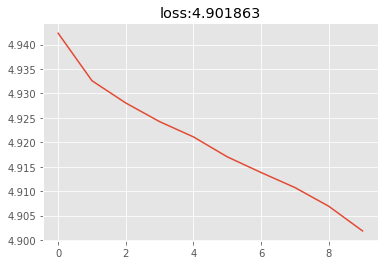

In [304]:
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(Method1Df.iloc[:-5], y1long, test_size=0.2, random_state=i)
# Standardize the train and test features
scaled_train_features = scale(X_train)
scaled_test_features = scale(X_test)
    

epochs =[25, 50, 75, 100]
layers = [[10,20,1], [15,20,1]]

    # Create the model
def model_func(layer):
    model_1 = Sequential()
    model_1.add(Dense(layer[0], 
        input_dim=scaled_train_features.shape[1], activation='relu'))
    model_1.add(Dense(layer[1], activation='relu'))
    model_1.add(Dense(layer[2], activation='linear'))
    return model_1

long_model_1 = Sequential()
long_model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
long_model_1.add(Dense(20, activation='relu'))
long_model_1.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
long_model_1.compile(optimizer='adam', loss=root_mean_squared_error)
history = long_model_1.fit(scaled_train_features, y_train, epochs=10, validation_data=(X_test,y_test))
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show() 

Train on 45639 samples, validate on 11410 samples
Epoch 1/10
45639/45639 [==============================] - 3s 67us/step - loss: 5.0507 - val_loss: 344.4197
Epoch 2/10
45639/45639 [==============================] - 2s 52us/step - loss: 5.0397 - val_loss: 3042.8079
Epoch 3/10
45639/45639 [==============================] - 2s 49us/step - loss: 5.0353 - val_loss: 3703.1751
Epoch 4/10
45639/45639 [==============================] - 2s 52us/step - loss: 5.0306 - val_loss: 5849.5827
Epoch 5/10
45639/45639 [==============================] - 2s 52us/step - loss: 5.0275 - val_loss: 6233.4969
Epoch 6/10
45639/45639 [==============================] - 2s 53us/step - loss: 5.0243 - val_loss: 6947.2373
Epoch 7/10
45639/45639 [==============================] - 2s 53us/step - loss: 5.0225 - val_loss: 6318.9416
Epoch 8/10
45639/45639 [==============================] - 2s 54us/step - loss: 5.0193 - val_loss: 5840.3124
Epoch 9/10
45639/45639 [==============================] - 2s 54us/step - loss: 5.0161 -

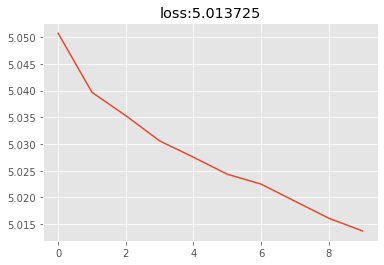

In [305]:
X_train, X_test, y_train, y_test = train_test_split(Method1Df.iloc[:-5], y1short, test_size=0.2, random_state=i)
# Standardize the train and test features
scaled_train_features = scale(X_train)
scaled_test_features = scale(X_test)
    

epochs =[25, 50, 75, 100]
layers = [[10,20,1], [15,20,1]]

    # Create the model
def model_func(layer):
    model_1 = Sequential()
    model_1.add(Dense(layer[0], 
        input_dim=scaled_train_features.shape[1], activation='relu'))
    model_1.add(Dense(layer[1], activation='relu'))
    model_1.add(Dense(layer[2], activation='linear'))
    return model_1

short_model_1 = Sequential()
short_model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
short_model_1.add(Dense(20, activation='relu'))
short_model_1.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
short_model_1.compile(optimizer='adam', loss=root_mean_squared_error)
history = short_model_1.fit(scaled_train_features, y_train, epochs=10, validation_data=(X_test,y_test))
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show() 

Train on 45798 samples, validate on 11450 samples
Epoch 1/10
45798/45798 [==============================] - 3s 73us/step - loss: 4.7391 - val_loss: 4.8762
Epoch 2/10
45798/45798 [==============================] - 3s 56us/step - loss: 4.6660 - val_loss: 4.8735
Epoch 3/10
45798/45798 [==============================] - 3s 57us/step - loss: 4.6556 - val_loss: 4.8815
Epoch 4/10
45798/45798 [==============================] - 3s 55us/step - loss: 4.6502 - val_loss: 4.8756
Epoch 5/10
45798/45798 [==============================] - 3s 57us/step - loss: 4.6440 - val_loss: 4.8635
Epoch 6/10
45798/45798 [==============================] - 3s 58us/step - loss: 4.6401 - val_loss: 4.8613
Epoch 7/10
45798/45798 [==============================] - 3s 57us/step - loss: 4.6332 - val_loss: 4.8692
Epoch 8/10
45798/45798 [==============================] - 3s 57us/step - loss: 4.6279 - val_loss: 4.8777
Epoch 9/10
45798/45798 [==============================] - 3s 57us/step - loss: 4.6214 - val_loss: 4.8819
Epoch

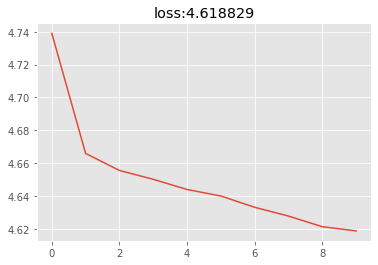

In [306]:

X_train, X_test, y_train, y_test = train_test_split(Method2Df.iloc[:-4], y2long, test_size=0.2, random_state=i)
# Standardize the train and test features

    
epochs =[25, 50, 75, 100]
layers = [[10,20,1], [15,20,1]]

    # Create the model
def model_func(layer):
    model_1 = Sequential()
    model_1.add(Dense(layer[0], 
        input_dim=X_train.shape[1], activation='relu'))
    model_1.add(Dense(layer[1], activation='relu'))
    model_1.add(Dense(layer[2], activation='linear'))
    return model_1

long_model_2 = Sequential()
long_model_2.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
long_model_2.add(Dense(20, activation='relu'))
long_model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
long_model_2.compile(optimizer='adam', loss=root_mean_squared_error)
history = long_model_2.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()  

Train on 45798 samples, validate on 11450 samples
Epoch 1/10
45798/45798 [==============================] - 3s 73us/step - loss: 4.8706 - val_loss: 4.7460
Epoch 2/10
45798/45798 [==============================] - 3s 57us/step - loss: 4.7934 - val_loss: 4.7221
Epoch 3/10
45798/45798 [==============================] - 2s 52us/step - loss: 4.7835 - val_loss: 4.7241
Epoch 4/10
45798/45798 [==============================] - 2s 51us/step - loss: 4.7783 - val_loss: 4.7253
Epoch 5/10
45798/45798 [==============================] - 2s 52us/step - loss: 4.7710 - val_loss: 4.7198
Epoch 6/10
45798/45798 [==============================] - 2s 52us/step - loss: 4.7692 - val_loss: 4.7109
Epoch 7/10
45798/45798 [==============================] - 2s 53us/step - loss: 4.7631 - val_loss: 4.7221
Epoch 8/10
45798/45798 [==============================] - 2s 52us/step - loss: 4.7572 - val_loss: 4.7111
Epoch 9/10
45798/45798 [==============================] - 2s 53us/step - loss: 4.7536 - val_loss: 4.7162
Epoch

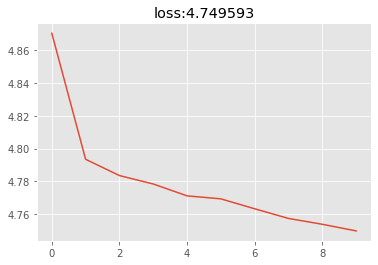

In [307]:
X_train, X_test, y_train, y_test = train_test_split(Method2Df.iloc[:-4], y2short, test_size=0.2, random_state=i)
# Standardize the train and test features

    
epochs =[25, 50, 75, 100]
layers = [[10,20,1], [15,20,1]]

    # Create the model
def model_func(layer):
    model_1 = Sequential()
    model_1.add(Dense(layer[0], 
        input_dim=X_train.shape[1], activation='relu'))
    model_1.add(Dense(layer[1], activation='relu'))
    model_1.add(Dense(layer[2], activation='linear'))
    return model_1

short_model_2 = Sequential()
short_model_2.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
short_model_2.add(Dense(20, activation='relu'))
short_model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
short_model_2.compile(optimizer='adam', loss=root_mean_squared_error)
history = short_model_2.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()  

In [308]:
X_train, X_test, y_train, y_test = train_test_split(Method2Df.iloc[:-4], y2long, test_size=0.2, random_state=i)

model3 = Sequential()
model3.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))

model3.add(Dense(256, activation='relu'))

model3.add(Dense(128, activation='relu'))

model3.add(Dense(1))

;
#rms = RMSprop()
#model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
model3.compile(loss='mean_absolute_error', optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1))
model3.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1, validation_data=(X_test,y_test) )

Train on 45798 samples, validate on 11450 samples
Epoch 1/10
45798/45798 [==============================] - 6s 123us/step - loss: 4.7493 - val_loss: 4.8887
Epoch 2/10
45798/45798 [==============================] - 5s 112us/step - loss: 4.6886 - val_loss: 4.8794
Epoch 3/10
45798/45798 [==============================] - 5s 111us/step - loss: 4.6746 - val_loss: 4.9018
Epoch 4/10
45798/45798 [==============================] - 5s 110us/step - loss: 4.6696 - val_loss: 4.8709
Epoch 5/10
45798/45798 [==============================] - 5s 109us/step - loss: 4.6625 - val_loss: 4.9021
Epoch 6/10
45798/45798 [==============================] - 5s 111us/step - loss: 4.6669 - val_loss: 4.8791
Epoch 7/10
45798/45798 [==============================] - 5s 109us/step - loss: 4.6590 - val_loss: 4.8845
Epoch 8/10
45798/45798 [==============================] - 5s 109us/step - loss: 4.6525 - val_loss: 4.8913
Epoch 9/10
45798/45798 [==============================] - 5s 109us/step - loss: 4.6627 - val_loss: 4.8